In [1]:
# import helper
import pandas as pd
from utils import *
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from IPython.display import Image
import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [22]:
tf.random.set_seed(15)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Data : We use the same data as used on Classical solutions

In [23]:
df = pd.read_csv('Processed_data.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Used data from Aug 2013 till 1st March 2024 
df=df[500:]
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [24]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_H-L', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
29


In [25]:
close_min=min(df['Close'].values)
close_max=max(df['Close'].values)
a=-1
b=1
normalized_df_2=(b-a)*((df-df.min())/(df.max()-df.min()))+a

In [26]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [27]:
df['Close']=normalized_df_2['Close']

In [28]:
sequence_length = 30
window =6

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,3):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return np.array(X_store), np.array(y_store)

In [29]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df)*0.96)
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 2758
Train sample 2647
Test sample 111


In [30]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

print(X_train.shape, y_train.shape)

(871, 30, 29) (871, 6)


In [31]:
# Test data
X_test, y_test = create_dataset(
    df_test,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

print(X_test.shape, y_test.shape)

(25, 30, 29) (25, 6)


# Proposed Approach

In [32]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model
from keras.layers.advanced_activations import PReLU
import tensorflow as tf

In [33]:
input_ = Input((30,29)) # feature
print(input_.shape)
den1=Dense(10, use_bias=True,activation=PReLU() )(input_)
print(den1.shape)
den2=Flatten()(den1)
print(den2.shape)
den3=Dense(16, use_bias=True,activation=PReLU()  )(den2)
print(den3.shape)
den4=Dense(8, use_bias=True,activation=PReLU()  )(den3)
print(den4.shape)
den5=Dense(6, use_bias=True,activation=PReLU() )(den4)
print(den5.shape)
model = Model(inputs=[input_], outputs=den5)

(None, 30, 29)
(None, 30, 10)
(None, 300)
(None, 16)
(None, 8)
(None, 6)


In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 29)]          0         
                                                                 
 dense_4 (Dense)             (None, 30, 10)            600       
                                                                 
 flatten_1 (Flatten)         (None, 300)               0         
                                                                 
 dense_5 (Dense)             (None, 16)                4832      
                                                                 
 dense_6 (Dense)             (None, 8)                 144       
                                                                 
 dense_7 (Dense)             (None, 6)                 60        
                                                                 
Total params: 5,636
Trainable params: 5,636
Non-trainable p

In [35]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss=loss_fn)

In [36]:
model_history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                   batch_size=1, 
                   epochs=10, shuffle=True
                   )

Epoch 1/10
871/871 [==============================] - 2s 2ms/step - loss: 0.0677 - val_loss: 0.0088
Epoch 2/10
871/871 [==============================] - 1s 2ms/step - loss: 0.0275 - val_loss: 0.0130
Epoch 3/10
871/871 [==============================] - 1s 1ms/step - loss: 0.0244 - val_loss: 0.0071
Epoch 4/10
871/871 [==============================] - 1s 1ms/step - loss: 0.0231 - val_loss: 0.0042
Epoch 5/10
871/871 [==============================] - 1s 1ms/step - loss: 0.0212 - val_loss: 0.0041
Epoch 6/10
871/871 [==============================] - 1s 1ms/step - loss: 0.0195 - val_loss: 0.0071
Epoch 7/10
871/871 [==============================] - 1s 1ms/step - loss: 0.0182 - val_loss: 0.0076
Epoch 8/10
871/871 [==============================] - 1s 1ms/step - loss: 0.0172 - val_loss: 0.0051
Epoch 9/10
871/871 [==============================] - 1s 1ms/step - loss: 0.0172 - val_loss: 0.0030
Epoch 10/10
871/871 [==============================] - 1s 1ms/step - loss: 0.0166 - val_loss: 0.0058

In [41]:
model_history.history['loss']

[0.06767186522483826,
 0.027514539659023285,
 0.024408001452684402,
 0.023123271763324738,
 0.02123534493148327,
 0.019537707790732384,
 0.018159469589591026,
 0.0172024667263031,
 0.017227893695235252,
 0.016574513167142868]

In [42]:
model_history.history['val_loss']

[0.008794895373284817,
 0.013040008954703808,
 0.0070557487197220325,
 0.004247294273227453,
 0.004133519716560841,
 0.007092826999723911,
 0.00756154116243124,
 0.005144184920936823,
 0.00297062611207366,
 0.005830429960042238]

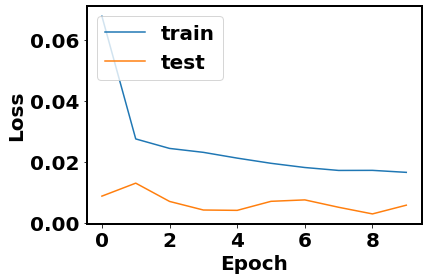

In [37]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=((((y_true[i]-a)/(b-a))*(close_max - close_min))+close_min)
        y2=((((y_pred[i]-a)/(b-a))*(close_max - close_min))+close_min)
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [39]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5

In [40]:
mae_train_pros, rmse_train_pros= cal_metrics(y_train,model.predict(X_train))
print('MAE train error is',mae_train_pros)
print('RMSE train error is',rmse_train_pros)

mae_test_pros, rmse_test_pros= cal_metrics(y_test,model.predict(X_test))
print('MAE test error is',mae_test_pros)
print('RMSE test error is',rmse_test_pros)

MAE train error is 115.51108093098222
RMSE train error is 131.6460097464489
MAE test error is 86.46691536458331
RMSE test error is 94.59358887926993
